In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from models import DNMC, NMC, NSurv, MLP

tf.random.set_seed(2021)

In [73]:
def generate_dataset(n_samples, noise=.5):

    from sklearn.datasets import make_moons, make_circles

    x0, c0 = make_moons(n_samples=n_samples, noise=noise, random_state=0)
    x1, c1 = make_circles(n_samples=n_samples, noise=noise, factor=.5, random_state=0)
    x2 = np.random.randn(n_samples, 1)
    x = np.concatenate([x0, x1, x2], axis=1)
    c = np.concatenate([c0[:, np.newaxis], c1[:, np.newaxis]], axis=1)
    x = x - np.mean(x, axis=0)

    max_time = 3

    xmu_coeffs = np.array([[0., 0., 0., 0., 1.], [0., 0., 0., 0., -1.]]).T
    mu_event = np.squeeze((x @ xmu_coeffs)) + .3
    sig_event = .25 * np.random.randn(n_samples, 2)

    event_times = np.exp(mu_event + sig_event * np.random.randn(n_samples, 2))
    
    plt.hist(event_times[:, 0], bins=1000)
    plt.show()
    censoring_times = max_time * np.random.rand(n_samples, 2)

    t = np.minimum(event_times, censoring_times)
    s = (t == event_times).astype(int)

    return x[:, 0], c[:, 0], t[:, 0], s[:, 0], event_times[:, 0], censoring_times[:, 0]

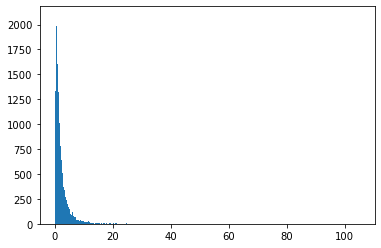

In [74]:
n_samples = 40000
x, e, y, s, t, c = generate_dataset(n_samples, noise=.5)

In [75]:
def discretize(*arrs, nbins=10, pad=1e-5, min_val=None, max_val=None):
    min_val = min_val or np.amin(np.stack(arrs))
    max_val = max_val or np.amax(np.stack(arrs))
    binsize = (max_val - min_val + pad) / nbins
    return ((arr - arr.min()) // binsize for arr in arrs)
    
def onehot(arr, ncategories=None):
    if ncategories is None:
        ncategories = len(np.unique(arr))
    return np.eye(ncategories)[arr.astype(int)]

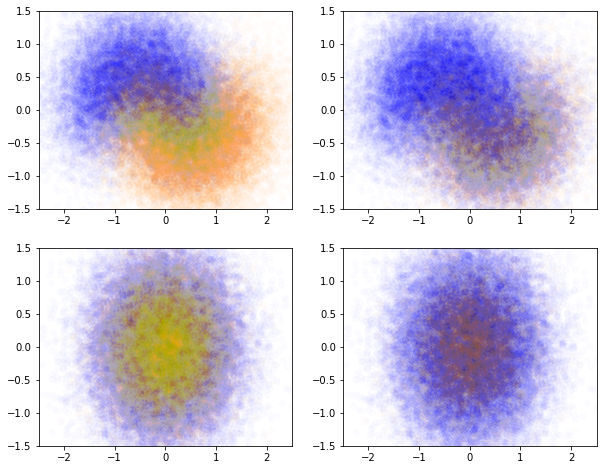

In [28]:
# visualize c (left) and s (right)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for i in range(2):

    ax[i, 0].scatter(x[e[:, i] == 0, 2 * i], x[e[:, i] == 0, 2 * i + 1], alpha=.01, c='blue')
    ax[i, 0].scatter(x[e[:, i] == 1, 2 * i], x[e[:, i] == 1, 2 * i + 1], alpha=.01, c='orange')

    ax[i, 1].scatter(x[s[:, i] == 0, 2 * i], x[s[:, i] == 0, 2 * i + 1], alpha=.01, c='blue')
    ax[i, 1].scatter(x[s[:, i] == 1, 2 * i], x[s[:, i] == 1, 2 * i + 1], alpha=.01, c='orange')

    for j in range(2):
        ax[i, j].set_xlim([-2.5, 2.5])
        ax[i, j].set_ylim([-1.5, 1.5])

plt.show()

In [76]:
N_BINS = 25

t_disc, c_disc, y_disc = discretize(t, c, y, nbins=N_BINS, min_val=0., max_val=3.)

In [77]:
len(t_disc)

40000

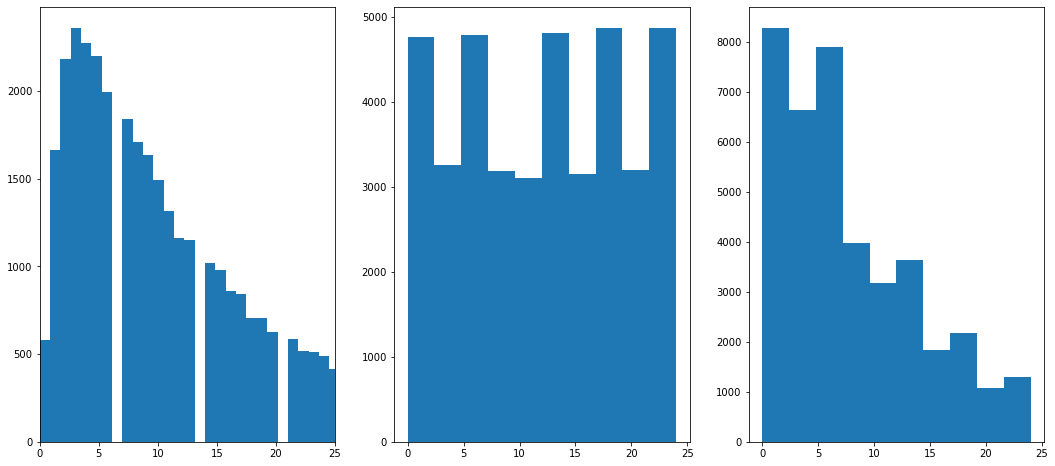

In [84]:
# visualize event times

fig, ax = plt.subplots(1, 3, figsize=(18, 8))

ax[0].hist(t_disc, bins=1000)
ax[0].set_xlim([0, 25])
ax[1].hist(c_disc)
ax[2].hist(y_disc)

plt.show()

In [40]:
t_disc

array([[1., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [4., 0.],
       [1., 0.],
       [1., 1.]])

In [11]:
t_disc_test, c_disc_test, y_disc_test = discretize(t, censoring)
c_disc, t_disc = discretize(c, t, nbins=10)
t = onehot(t_disc, ncategories=10)

In [18]:
# partition into train and validation sets

val_idx = 3 * n_samples // 5
test_idx = 4 * n_samples // 5

x_train = x[:val_idx]
t_train = t[:val_idx]
s_train = s[:val_idx]
c_train = c[:val_idx]

x_val = x[val_idx:test_idx]
t_val = t[val_idx:test_idx]
s_val = s[val_idx:test_idx]
c_val = c[val_idx:test_idx]

x_test = x[test_idx:]
t_test = t[test_idx:]
s_test = s[test_idx:]
c_test = c[test_idx:]

c_disc_test = c_disc[test_idx:]
t_disc_test = t_disc[test_idx:]

In [16]:
def get_batches(*arrs, batch_size=1):
    l = len(arrs[0])
    for ndx in range(0, l, batch_size):
        yield (arr[ndx:min(ndx + batch_size, l)] for arr in arrs)
        
import time

def train_model(
    model, train_data, val_data, n_epochs,
    batch_size=50, learning_rate=1e-3, early_stopping_criterion=2):

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    #@tf.function
    def train_step(x, y, s):
        with tf.GradientTape() as tape:
            train_loss, train_nll = model.loss(x, y, s)
            #print(train_loss, train_nll)
        grads = tape.gradient(train_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return train_loss, train_nll

    #@tf.function
    def test_step(x, y, s):
        val_loss, val_nll = model.loss(x, y, s)
        return val_loss, val_nll
    
    best_val_loss = np.inf
    no_decrease = 0

    for epoch_idx in range(n_epochs):

        #print("\nStart of epoch %d" % (epoch_idx,))
        start_time = time.time()

        train_losses = []
        train_nlls = []

        for batch_idx, (xt, yt, st) in enumerate(get_batches(*train_data, batch_size=batch_size)):

            train_loss, train_nll = train_step(xt, yt, st)

            train_losses.append(train_loss)
            train_nlls.append(train_nll)

        # Display metrics at the end of each epoch.
        #print('Epoch training loss: %.4f, NLL = %.4f' % (np.mean(batch_losses), np.mean(batch_nll)))

        val_losses = []
        val_nlls = []

        # Run a validation loop at the end of each epoch.
        for batch_idx, (xv, yv, sv) in enumerate(get_batches(*val_data, batch_size=batch_size)):

            val_loss, val_nll = test_step(xv, yv, sv)

            val_losses.append(val_loss)
            val_nlls.append(val_nll)
            
        new_val_loss = np.mean(val_losses)

        print(
            'Epoch %2i | Train Loss: %.4f | Train NLL: %.4f | Val Loss: %.4f | Val NLL: %.4f'
            % (epoch_idx, np.mean(train_losses), np.mean(train_nlls), np.mean(val_losses), np.mean(val_nlls))
        )
        #print('Time taken: %.2fs' % (time.time() - start_time))
                
        if new_val_loss > best_val_loss:
            no_decrease += 1
        else:
            no_decrease = 0
            best_val_loss = new_val_loss
            
        if no_decrease == early_stopping_criterion:
            break

In [17]:
from sklearn.metrics import roc_auc_score


def nll(t_true, t_pred, tol=1e-8):
    ncat = np.shape(t_pred)[1]
    nll_ = -1 * np.log(np.sum(onehot(t_true, ncategories=ncat) * t_pred, axis=1) + tol)
    return np.mean(nll_)


def evaluate_model(
    model, test_data, e_test, t_disc_test, c_disc_test, y_disc_test, 
    batch_size=50, dataset='support', factors='unknown'):
    
    modelname = type(model).__name__
    
    test_losses = []
    test_nlls = []
    
    test_e_pred = []
    test_t_pred = []
    test_c_pred = []
    
    for batch_idx, (xt, yt, st) in enumerate(get_batches(*test_data, batch_size=batch_size)):
        
        test_loss, test_nll = model.loss(xt, yt, st)
        
        if modelname == 'NSurv':
            t_pred, c_pred = model(xt)
            test_t_pred.append(t_pred)
            test_c_pred.append(c_pred)
        elif modelname == 'MLP':
            e_pred = model(xt)
            test_e_pred.append(e_pred)
        else:
            e_pred, t_pred, c_pred = model(xt)
            test_e_pred.append(e_pred)
            test_t_pred.append(t_pred)
            test_c_pred.append(c_pred)
        
        test_losses.append(test_loss)
        test_nlls.append(test_nll)
    
    if modelname == 'NSurv':
        e_auc = None
    else:
        e_auc = roc_auc_score(e_test, np.concatenate(test_e_pred, axis=0))
        
    if modelname == 'MLP':
        t_nll = None
        c_nll = None
    else:
        t_nll = nll(t_disc_test, np.concatenate(test_t_pred, axis=0))
        c_nll = nll(c_disc_test, np.concatenate(test_c_pred, axis=0))
    
    results = {
        'dataset': dataset,
        'factors': factors,
        'model': modelname,
        'ld': model.ld,
        'lr': model.lr,
        'avg_test_loss': np.mean(test_losses),
        'avg_test_nll': np.mean(test_nlls),
        'e_auc': e_auc,
        't_nll': t_nll,
        'c_nll': c_nll
    }
    
    return results

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90


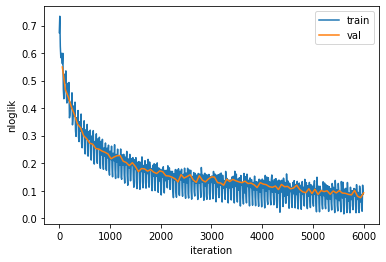

In [41]:
# Run NMC Model

model = NMC(
    e_layer_sizes=(50,),
    t_layer_sizes=(50,),
    n_bins=10
)

train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)

evaluate_model(
    model, (x_test, t_test, s_test),
    c_test, t_disc_test, c_disc_test, y_disc_test,
    factors='separate')

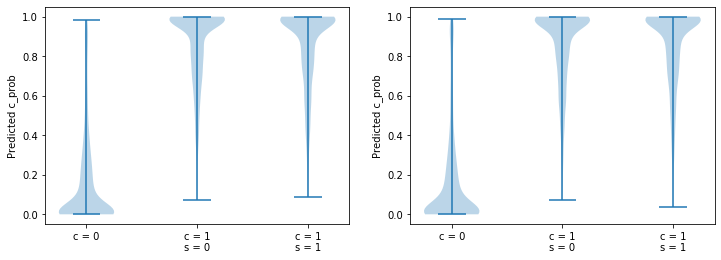

In [42]:
# Visualize CFT Predictions

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    ax[i].violinplot([
        c_pred_cft[c_test[:, i] == 0, i],
        c_pred_cft[(c_test[:, i] == 1) & (s_test[:, i] == 0), i],
        c_pred_cft[(c_test[:, i] == 1) & (s_test[:, i] == 1), i]])
    ax[i].set_xticks([1, 2, 3])
    ax[i].set_xticklabels(['c = 0', 'c = 1\ns = 0', 'c = 1\ns = 1'])
    ax[i].set_ylabel('Predicted c_prob')

plt.show()

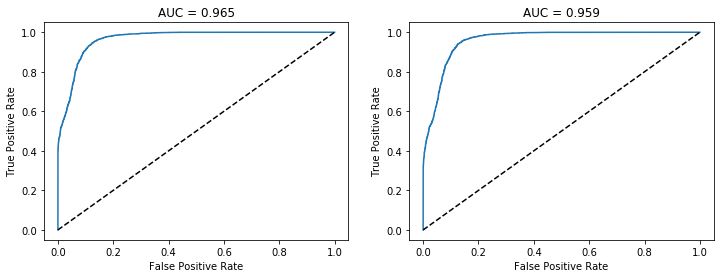

In [43]:
# CFT performance in predicting c

from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    fpr, tpr, _ = roc_curve(c_test[:, i], c_pred_cft[:, i])
    ax[i].plot(fpr, tpr)
    ax[i].plot([0, 1], [0, 1], 'k--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title('AUC = %.3f' % roc_auc_score(c_test[:, i], c_pred_cft[:, i]))

plt.show()

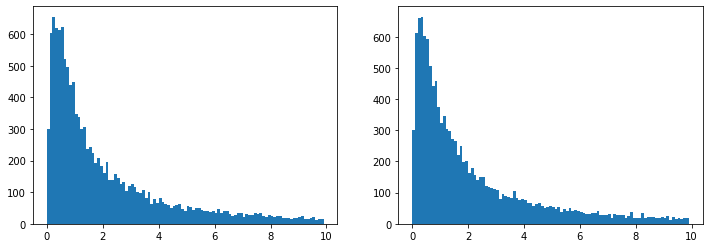

In [9]:
# CFT event time predictions

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    ax[i].hist(t_pred_cft[:, i].flatten(), bins=np.arange(100) / 10)

plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90


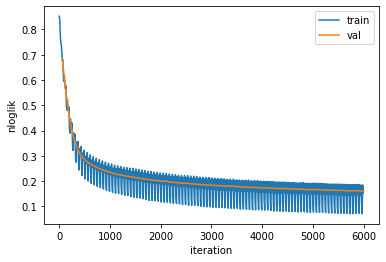

In [14]:
# Train deep survival model (not conditional)

tf.reset_default_graph()

surv_mdl = SurvivalModel(
    decoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = surv_mdl.train(
        sess,
        [x_train, c_train, t_train, s_train],
        [x_val, c_val, t_val, s_val],
        100, max_epochs_no_improve=10, learning_rate=1e-3,
        verbose=False)
    t_pred_surv = surv_mdl.predict(sess, x_test)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90


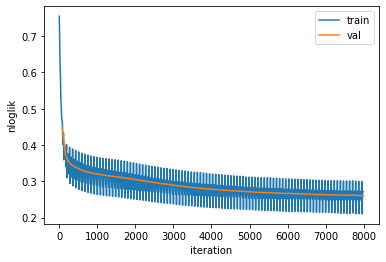

In [16]:
# Train MLP to predict s directly

tf.reset_default_graph()

posneg_mdl = PosNegModel(
    encoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = posneg_mdl.train(
        sess, [x_train, s_train], [x_val, s_val],
        100, max_epochs_no_improve=10, learning_rate=1e-3,
        verbose=False)
    s_pred_posneg = posneg_mdl.predict(sess, x_test)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90


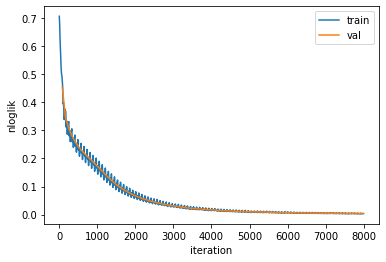

In [17]:
# Train MLP to predict c directly (to see optimal classification performance)

tf.reset_default_graph()

c_mdl = PosNegModel(
    encoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = c_mdl.train(
        sess, [x_train, c_train], [x_val, c_val],
        100, max_epochs_no_improve=10, learning_rate=1e-3,
        verbose=False)
    c_pred_posneg = c_mdl.predict(sess, x_test)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

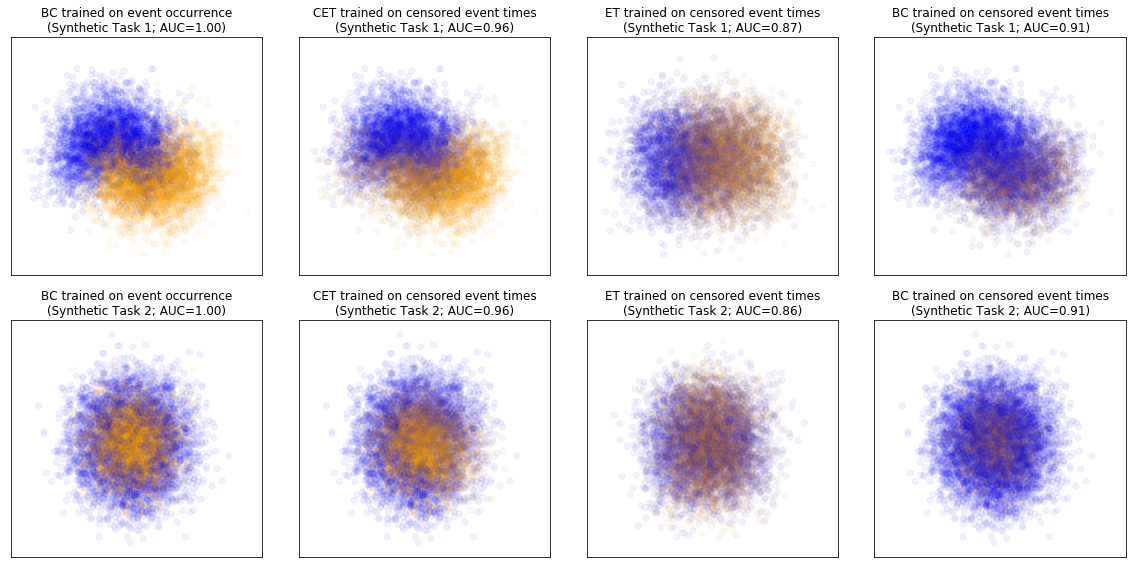

In [44]:
# Compare results between models

from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list('BuOr', ['blue', 'orange'], N=100)

def time_to_prob(x):
    sorted_pos = {v: pos for pos, v in enumerate(sorted(x))}
    return 1 - np.array([sorted_pos[v] / len(x) for v in x])

def t_to_prob(x):
    return np.stack([time_to_prob(arr) for arr in x.T]).T

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey=True, sharex=True)

for i in range(2):

    ax[i, 0].scatter(x_test[:, 2 * i], x_test[:, 2 * i + 1], c=c_pred_posneg[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 0].set_title('BC trained on event occurrence\n(Synthetic Task %i; AUC=%.2f)' % (i + 1, roc_auc_score(
        c_test[:, i], c_pred_posneg[:, i])), fontsize=12)
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ax[i, 1].scatter(x_test[:, 2 * i], x_test[:, 2 * i + 1], c=c_pred_cft[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 1].set_title('CET trained on censored event times\n(Synthetic Task %i; AUC=%.2f)' % (i + 1, roc_auc_score(
        c_test[:, i], c_pred_cft[:, i])), fontsize=12)
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    
    t_prob_surv = t_to_prob(t_pred_surv)
    ax[i, 2].scatter(x_test[:, 2 * i], x_val[:, 2 * i + 1], c=t_prob_surv[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 2].set_title('ET trained on censored event times\n(Synthetic Task %i; AUC=%.2f)' % (i + 1, roc_auc_score(
        c_test[:, i], t_prob_surv[:, i])), fontsize=12)
    ax[i, 2].set_xticks([])
    ax[i, 1].set_yticks([])
    
    ax[i, 3].scatter(x_test[:, 2 * i], x_test[:, 2 * i + 1], c=s_pred_posneg[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 3].set_title('BC trained on censored event times\n(Synthetic Task %i; AUC=%.2f)' % (i + 1, roc_auc_score(
        c_test[:, i], s_pred_posneg[:, i])), fontsize=12)
    ax[i, 3].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()
plt.savefig('/Users/mme/Downloads/fig1.pdf')
plt.show()

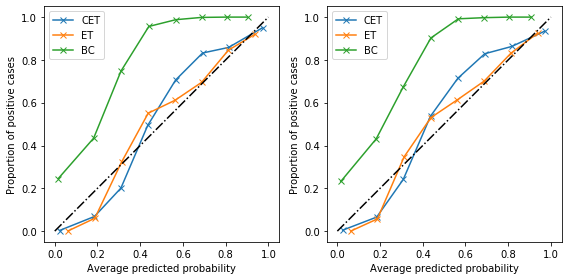

In [47]:
# Visualize calibration

from sklearn.calibration import calibration_curve

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

for i in range(2):
    pt, pp = calibration_curve(c_test[:, i], c_pred_cft[:, i], normalize=False, n_bins=8)
    ax[i].plot(pp, pt, 'x-', label='CET')
    pt, pp = calibration_curve(c_test[:, i], t_prob_surv[:, i], normalize=False, n_bins=8)
    ax[i].plot(pp, pt, 'x-', label='ET')
    pt, pp = calibration_curve(c_test[:, i], s_pred_posneg[:, i], normalize=False, n_bins=8)
    ax[i].plot(pp, pt, 'x-', label='BC')
    ax[i].plot([0, 1], [0, 1], 'k-.')
    ax[i].legend()
    ax[i].set_xlabel('Average predicted probability')
    ax[i].set_ylabel('Proportion of positive cases')

plt.tight_layout()
plt.savefig('/Users/mme/Downloads/fig2.pdf')